In [1]:
# 以下代码请在Kaggel的Kernel下运行，并且使用tpu
!pip install -q efficientnet

In [2]:
#导入核心库
import tensorflow as tf
import efficientnet.tfkeras as efn # 核心网络
import numpy as np # 矩阵处理
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
# 高级统计数据
import matplotlib.pyplot as plt # 画图
import re # 统计图片数量
import json # 保存一些信息
from math import cos,pi,e # 构造学习率调度函数
from time import perf_counter # 用于计算时间
print('Tensorflow ver:',tf.__version__) # 导入完成！

Tensorflow ver: 2.1.0


In [3]:
try:
    #解析TPU芯片集群
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    #kaggle不需要喂参数，他默认好了
    tf.config.experimental_connect_to_cluster(tpu)
    # 配置运算器
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # 初始化tpu系统
    print('TPU configured, at',tpu.master())
    # 查看tpu地址（远程）
except ValueError: #本地运行，CPU
    tpu = None
    print('TPUs not found! Using CPU')

#获得分配策略，进行并行运算，以提升训练速度
if tpu:
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Succeed distributing TPUs!')
print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU configured, at grpc://10.0.0.2:8470
Succeed distributing TPUs!
REPLICAS:  8


In [4]:
#后面很多核心函数都有优化参数，根据性能自动选择
AUTO = tf.data.experimental.AUTOTUNE
print('AUTO:',AUTO)

#超参数定义
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # 根据cpu/tpu自动调整batch大小
EPOCHS = 12 # 训练周次，对应这个模型，12周最好


IMAGE_SIZE = [512,512] #手动修改此处图像大小，进行训练
WIDTH = IMAGE_SIZE[0]
HEIGHT = IMAGE_SIZE[1]
CHANNELS = 3
# label数字对应CLASSES下标，得到label名字
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'
           ]

AUTO: -1


In [5]:
# 加载官方数据集
try: #Running in Kaggle kernel
    from kaggle_datasets import KaggleDatasets
    BASE = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
except ModuleNotFoundError: # 本地运行
    BASE = "替换成自己的路径"

IMAGE_PATH = BASE + '/tfrecords-jpeg-512x512'

#此处利用tf.io的库函数
#读出文件集方式很多种，也可以用os+re库进行
TRAINING_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(IMAGE_PATH + '/test/*.tfrec')

In [6]:
# 统计image数量，用于计算每个epoch随机批梯度下降的次数，保证所有图片都能被训练
# 每个tfrec文件前面都是图片的数量，如0-512x512-123.tfrec，123就是图片数量
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]+)\.").match(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
#下面是核心函数构造，自顶向下
def get_training_dataset(do_aug=True):
    #严格遵循代码开头注释流程
    # do_aug means do augmentation
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True) #labeled参数是用来判断数据有没有label的，比如test dataset就没有label
    #装载分离好等数据，每个example含image，class等等，其中kaggle说image的图像是jpeg格式的
    if do_aug:
        dataset = dataset.map(data_augmentation, num_parallel_calls=AUTO)
    #进行数据扩容，此步非常重要！可大大提升训练精度，已被广泛使用，不用你就out了
    dataset = dataset.shuffle(2048)
    # 每次取2048个examples，打乱。这个值不用过大也不要过小
    dataset = dataset.batch(BATCH_SIZE)
    #批处理
    dataset = dataset.repeat()
    #repeat无参数说明无限重复dataset。放心，不会内存溢出，只是懒循环罢了
    dataset = dataset.prefetch(AUTO)
    # 根据cpu决定是否提前准备数据。为什么要这么做？原因是我想采用tpu进行训练，
    # 那么在tpu在训练时，cpu可以预先把下一批图像load到内存，当
    # tpu训练好了，直接又能进行下一批当训练，减少了训练时间。
    # 还是那句话，不用，你就out了 
    return dataset

def get_validation_dataset(order=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True,ordered=order)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #cache dataset到memory，加速训练时间，只有3712张
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(order=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False,ordered=order)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

#完善核心函数中的小函数
def load_dataset(filenames, labeled=True, ordered=False):
    #ordered参数是指并行读取数据时不必在意是否按照原来顺序，加快速度
    #顺序不重要的= =

    #不在意顺序预处理
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #详见help

    #利用API导入初始TFrec文件集数据
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    #设置dataset，让他保持并行读出来的顺序就行了
    dataset = dataset.with_options(ignore_order)
    #根据label决定传入带标签的解析函数，还是不带标签（test只有id）的解析函数
    dataset = dataset.map(read_labeled_tfrecord if labeled
                     else read_unlabeled_tfrecord, 
                     num_parallel_calls=AUTO)
    return dataset #现在dataset的每个data有两个部分了，一个是image，一个是class或id号

def data_augmentation(image, label):
    #所谓数据扩容，就是把原来的照片左移或右移，或上下左右反转一下，就得到了“新”图像
    #此方法利用了现实世界的平移不变形和空间不变形

    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.1) # 亮度增强好像对性能影响不大

    # 还有下列api进行更无聊的处理
    # 'random_contrast', 对比度
    # 'random_crop', 缩放
    # 'random_hue', 色相
    # 'random_jpeg_quality',  图片质量
    # 'random_saturation' 饱和度
    return image, label   

def decode_image(image_data):
    # 由于给的图像是jpeg格式，故用对应api进行处理。
    # 现在image_data只是一个byte向量，其每个元素的值在
    image = tf.image.decode_jpeg(image_data, channels=3)
    # 得到tf.Tensor形式的image
    image = tf.cast(image, tf.float32)
    image /= 255.0
    # 将image的每个数值调整在[0,1]之间，方便训练
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    # reshape此部非常重要，调试的时候被坑了，老是说什么shape不匹配
    return image

def read_labeled_tfrecord(example):
    FEATURE = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)  
    }
    example = tf.io.parse_single_example(example, FEATURE)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label #返回一个以 图像数组和标签形式的数据集

def read_unlabeled_tfrecord(example):
    FEATURE = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, FEATURE)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum


In [8]:
# 一些展示训练结果的函数
def show_acc_loss(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Efficient net b7')
    plt.legend()
    plt.savefig('acc.jpg')

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss & CE')
    plt.title('Efficient net b7')
    plt.legend()

    plt.savefig('loss.jpg')

    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()

    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.savefig('confusion_matrix.jpg')
    plt.show()

In [9]:
# 创建efnb7 & custom classifier
with strategy.scope():
    conv_base = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )
    # acc means val_acc here, not train acc.
    # Full training acc -> 95.4% (10epochs)
    # fine-tune at b7a acc -> 93.59% 12epochs
    # b6a loss -> 0.2687 - acc: 0.9467 11 epochs
    # b5a loss -> 0.2417 - acc: 0.9537 12e pochs
    # b4a loss -> 0.2411 - acc: 0.9539 12 epochs
    # b2a loss -> 0.2212 - acc: 0.9582 13 epochs
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block2a_expand_conv':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    # dropout : val_acc
    # 0 : 95.8
    # 0.2 : 95.82
    # Conclusion: No improved adding dropout at classifier.

    # 第四轮lr不能大于2e-4,后面几轮学习率必须每一轮都要下降
    model = tf.keras.Sequential([
        conv_base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.1), #可有可无的dropout，但多少好那么一点点。。
        tf.keras.layers.Dense(104, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

258441216/258434480 [==============================] - 8s 0us/step


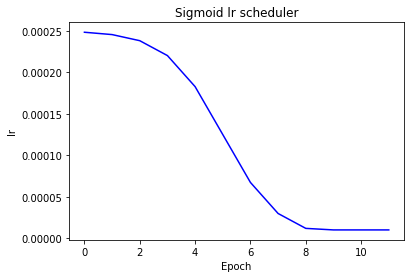

In [10]:
# 设置学习率调度器
# 事实证明，sigmoid更平滑些

def lrfn(epoch): #用cos进行退火
    LR_START = 2.5e-4
    LR_MIN = 1e-5

    lr = cos(epoch*pi/18) * LR_START

    return lr if lr>LR_MIN else LR_MIN

def lrfn1(epoch): # 用sigmoid进行学习率退火
    lr_start = 2.5e-4
    lr_min = 1e-5

    lr = lr_start / (1 + e ** (epoch - 5))
    return lr if lr > lr_min else lr_min

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2
    ),
    tf.keras.callbacks.LearningRateScheduler(
        lrfn1,
        verbose=1
    )
]

epochs=[x for x in range(12)]
lr_sigmoid=[lrfn1(x) for x in epochs]
plt.plot(epochs,lr_sigmoid,'b')
plt.xlabel('Epoch')
plt.ylabel('lr')
plt.title('Sigmoid lr scheduler')
plt.savefig('lr_sche.jpg')
plt.show()

In [11]:
#开 始 训 练 ?
nums_image = count_data_items(TRAINING_FILENAMES)
STEPS_PER_EPOCH = nums_image // BATCH_SIZE #每个epoch所要重复获取数据然后训练的次数
print('Total {} images will be training..'.format(nums_image))

# 这里不能数据增强，否则loss会出现Nan，具体原因时添加了额外训练集
# 增强这些训练集就会这样，但官方的没事，我很奇怪
# 2020.5.7:可以使用随机左右翻转augment
history = model.fit(get_training_dataset(do_aug=True),
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=get_validation_dataset(),
                    callbacks=callbacks_list,
                    verbose=2
                    )

Total 12753 images will be training..
Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002483267872689288.
Epoch 1/12
99/99 - 360s - loss: 2.4322 - sparse_categorical_accuracy: 0.4899 - val_loss: 0.8913 - val_sparse_categorical_accuracy: 0.7804

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002455034475094771.
Epoch 2/12
99/99 - 197s - loss: 0.7246 - sparse_categorical_accuracy: 0.8284 - val_loss: 0.4380 - val_sparse_categorical_accuracy: 0.8939

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002381435317056083.
Epoch 3/12
99/99 - 85s - loss: 0.3985 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.2878 - val_sparse_categorical_accuracy: 0.9300

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002201992694944706.
Epoch 4/12
99/99 - 85s - loss: 0.2718 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2362 - val_sparse_categorical_accuracy: 0.9407

Epoch 00005: LearningRateScheduler reducing learning

Model saving...


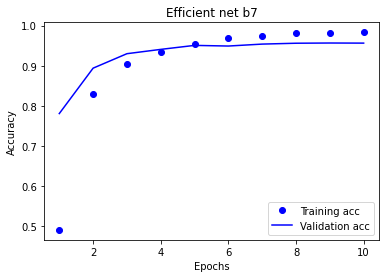

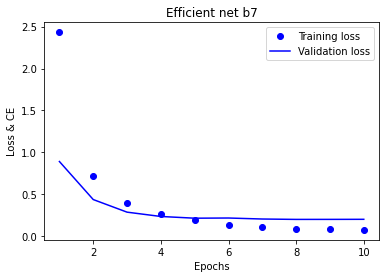

In [12]:
# 保存权重就好
# 如果整个model保存下来，tf2.1在load_model会出现错误，算是bug
print('Model saving...')
model.save_weights('my_weights.h5')
show_acc_loss(history)

In [13]:
#prediction test_dataset
print('Preparing test dataset...')
test_ds = get_test_dataset(order=True)

print('Predicting test dataset...')
test_images = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images)
predictions = np.argmax(probabilities, axis=-1)
# 找出每行最大值的index

print('Generating submission.csv file...')
nums_test_images = count_data_items(TEST_FILENAMES)
test_ids = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids.batch(nums_test_images))).numpy().astype('U')
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
print('Successfully generating csv submission file!')


Preparing test dataset...
Predicting test dataset...
Generating submission.csv file...
Successfully generating csv submission file!


Preparing dataset...
Predicting...
In 23.0s compeleted!
Computing mistakes...


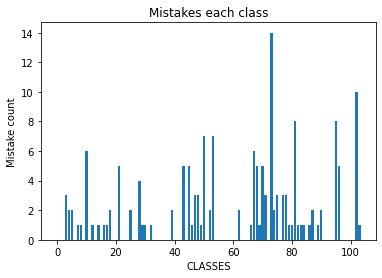

In [14]:
# 加载验证集,为了得到f1 score
print('Preparing dataset...')
dataset = get_validation_dataset(order=True)
images = dataset.map(lambda image, label: image)
labels = dataset.map(lambda image, label: label).unbatch()

# 用验证集预测
print('Predicting...')
prediction_start = perf_counter()
output = model.predict(images) # output.shape = (3712,104)
prediction_end = perf_counter()
print('In {:.1f}s compeleted!'.format(prediction_end - prediction_start))
prediction = np.argmax(output,axis=-1)

# 直接获得正确标签整个整体，batch的话还要写多一个循环
nums_validation_images = count_data_items(VALIDATION_FILENAMES)
correct_labels = next(iter(labels.batch(nums_validation_images))).numpy()

mistake = [0 for _ in range(len(CLASSES))] # 104 classes
print('Computing mistakes...')
for i in range(nums_validation_images):
    if prediction[i] != correct_labels[i]:
        mistake[correct_labels[i]]+=1

with open('mistake.json','w') as f:
    json.dump(mistake,f)


classes = [x for x in range(104)]
plt.bar(classes,mistake)
plt.xlabel('CLASSES')
plt.ylabel('Mistake count')
plt.title('Mistakes each class')
plt.savefig('mistake.jpeg')
plt.show()

Spawning confusion matrix...


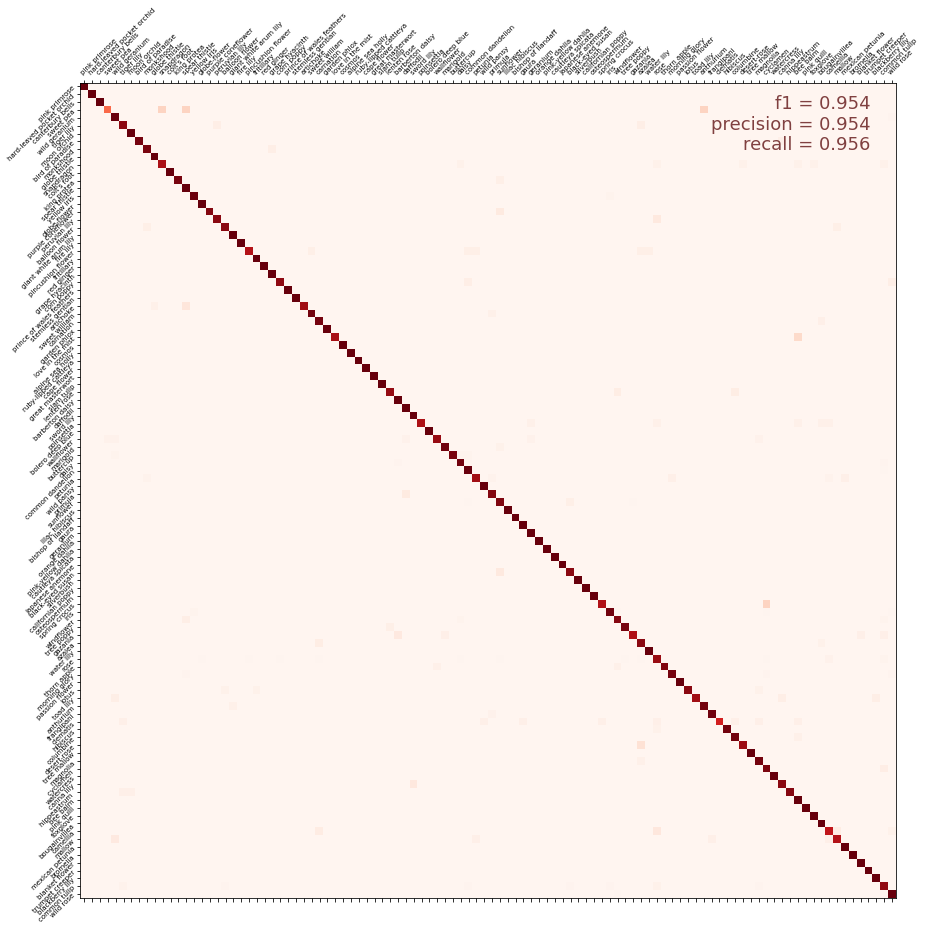

f1 score: 0.954, precision: 0.954, recall: 0.956


In [15]:
#spawn confusion matrix
print('Spawning confusion matrix...')
confusion_mat = confusion_matrix(correct_labels, prediction, labels=range(len(CLASSES)))
score = f1_score(correct_labels, prediction, labels=range(len(CLASSES)), average='macro')
precision = precision_score(correct_labels, prediction, labels=range(len(CLASSES)), average='macro')
recall = recall_score(correct_labels, prediction, labels=range(len(CLASSES)), average='macro')
confusion_mat = (confusion_mat.T / confusion_mat.sum(axis=1)).T # normalized
display_confusion_matrix(confusion_mat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
